# Machine Learning - Report 1

The purpose of this report is to analyze a dataset containing features of various forested areas. The dataset contains geographical characteristics of the area as well as the type of forest canopy that grows there. 

In [115]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, re

The `seaborn` library is imported to easily configure `matplotlib` to use publication-quality plot settings.

In [166]:
import seaborn as sns
sns.set_theme(); sns.set_palette('deep'); sns.set_palette([sns.color_palette()[i] for i in [0,1,2,3,4,7,9]])
plt.rc('legend', fontsize=8); plt.rc('xtick', labelsize=9); plt.rc('ytick', labelsize=9); plt.rc('axes', labelsize=10), plt.rc('axes', titlesize=12) 

The `scikit-learn-intelex` import proves to be very helpful for training machine learning models on an Intel architecture. It optimizes `scikit-learn` with directives optimized for Intel hardware, achieving a 10x increase in execution speed.

In [117]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, we import the dataset as a DataFrame and observe the features.

In [118]:
data = pd.read_csv('Datasets/train_r1.csv')
data

,altitude,exposure,ground_slant,water_distance,water_altitude,path_distance,morning_shade,midday_shade,evening_shade,fire_distance,wilderness_area,soil_class,forest_canopy
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
464805,2405,159,22,90,19,120,237,238,119,824,3,2,3
464806,2391,152,19,67,12,95,240,237,119,845,3,2,3
464807,2386,159,17,60,7,90,236,241,130,854,3,2,3
464808,2384,170,15,60,5,90,230,245,143,864,3,2,3


We use the `info()` method of the DataFrame primarily to evaluate whether the dataset has any missing values. 

In [119]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464810 entries, 0 to 464809
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   altitude         464810 non-null  int64
 1   exposure         464810 non-null  int64
 2   ground_slant     464810 non-null  int64
 3   water_distance   464810 non-null  int64
 4   water_altitude   464810 non-null  int64
 5   path_distance    464810 non-null  int64
 6   morning_shade    464810 non-null  int64
 7   midday_shade     464810 non-null  int64
 8   evening_shade    464810 non-null  int64
 9   fire_distance    464810 non-null  int64
 10  wilderness_area  464810 non-null  int64
 11  soil_class       464810 non-null  int64
 12  forest_canopy    464810 non-null  int64
dtypes: int64(13)
memory usage: 46.1 MB
None


Given that there are no missing values, we proceed to select the feature to be predicted as the Y_feature, and partition the dataframe into X and Y values. Our goal is to classify data points into the classes of the categorical variable forest_canopy.

In [120]:
Y_feature = 'forest_canopy'
Y = data[Y_feature]
N = len(data[Y_feature].unique())
X = data.drop(columns=[Y_feature])

## Preliminary evaluation of the dataset

Before executing any machine learning algorithms, we shall study the dataset through qualitative observations in order to make some preliminary observations, and make possible optimizations to the machine learning model if necessary. 

The simplest analysis that can be made is observing the distribution of classes in the target variable. If the classes are very unbalanced this will need to be taken into account when separating the dataset into a training set and a testing set. 

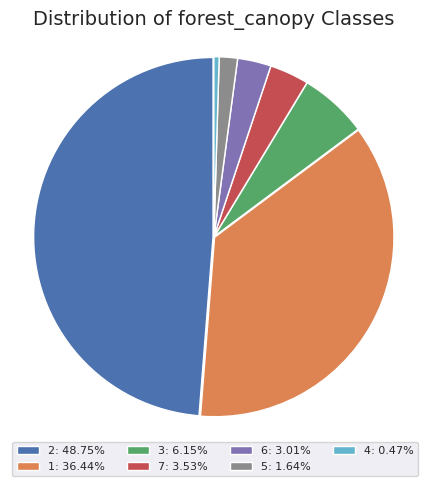

In [121]:
plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots(1,1)
cs = Y.value_counts()

ax.pie(cs.values, explode=0.005+np.zeros(len(Y.unique())), radius=1.1, startangle=90)
ax.legend([f"{cat}: {round(pct,2)}%" for (cat, pct) in zip(cs.index, 100*cs.values/sum(cs.values))], ncol=4, loc='lower right', bbox_to_anchor=(1.015,-0.1))
ax.title.set_text(f"Distribution of {Y_feature} Classes")
ax.title.set_fontsize(14)
plt.tight_layout()

Next we can search for single variables that could be correlated with the forest canopy class, since forest_canopy is a categorical feature, we make use of partitioned histograms to perform the analysis. 

Because of the unbalanced distribution of the classes, the histograms are shown individually normalized for each class for better visualization.

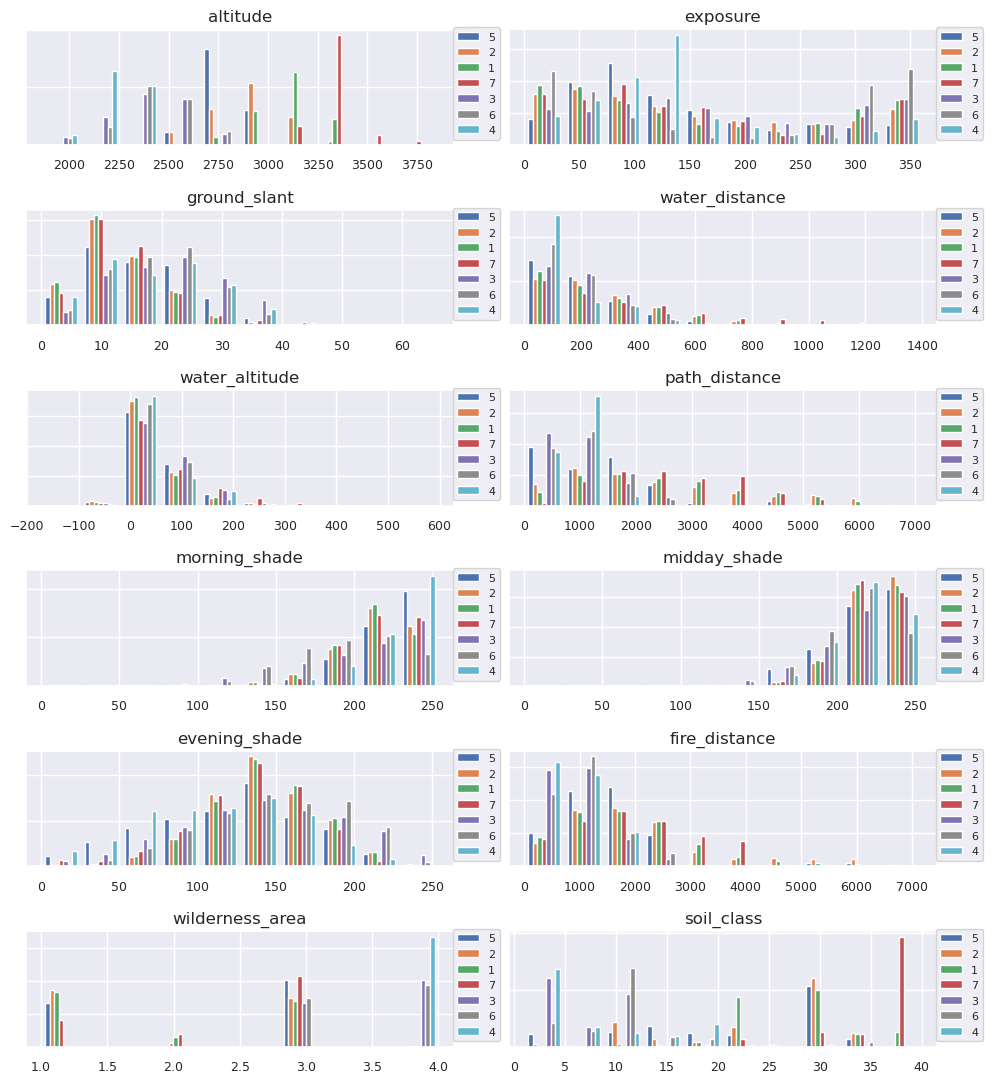

In [122]:
plt.rcParams["figure.figsize"] = (10,11)
plt.rcParams["lines.markersize"] = 0.25
fig, axs = plt.subplots(6,2)
k = 0
for i in range(0,6):
    for j in range(0,2):
        feat = X.columns[k]
        sel = [data[data[Y_feature]==i][feat] for i in data[Y_feature].unique()]
        axs[i,j].hist(sel, density=True)
        axs[i,j].title.set_text(feat)
        axs[i,j].yaxis.set_ticklabels([])
        axs[i,j].legend(data[Y_feature].unique(), loc='lower right', bbox_to_anchor=(1.12,0))
        k+=1
plt.tight_layout()

From the histograms only, some preliminary observations can be made:

- The altitude feature is highly informative for all classes
- The categorical features wilderness_area and soil_class are highly informative 
- A low ground_slant value favors classes **5**, **2**, **1**, and **7**, while higher ground_slant values favor classes **3**, **6**, and **4**
- Low values in path_distance or fire_distance favor classes **3**, **6**, and **4**
- Low evening_shade and high morning_shade values strongly favor classes **5** and **4**.

Since altitude appears to be the feature most strongly correlated with the forest canopy class, we can search for potential two-variable correlations of altitude and some other feature with our target feature. We do this by means of color-coded scatter plots.

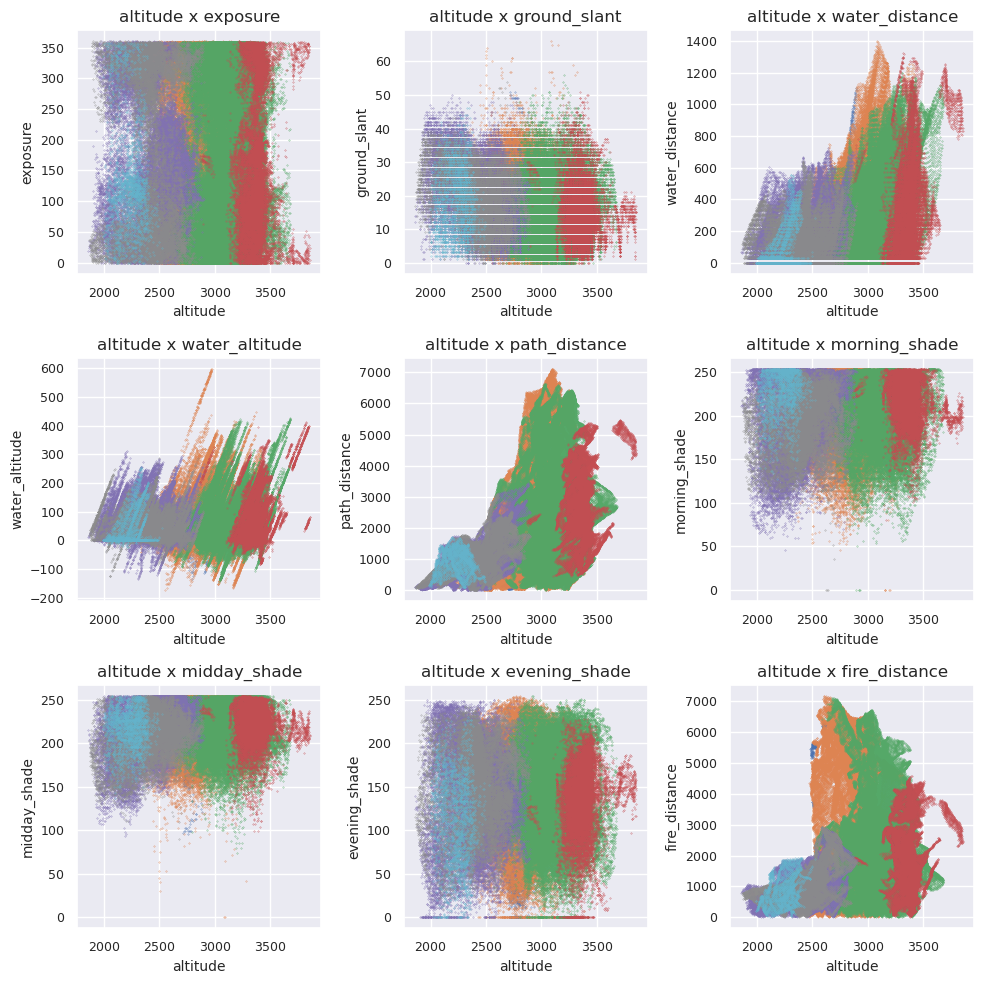

In [123]:
plt.rcParams["figure.figsize"] = (10,10)

def plt_scatter(ax, feature1, feature2):
    for i in data[Y_feature].unique():
        ax.scatter(data[data[Y_feature]==i][feature1], data[data[Y_feature]==i][feature2])
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.title.set_text(f"{feature1} x {feature2}")

def plt_scatters(xfeature):
    fig, axs = plt.subplots(3,3)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            if X.columns[k] == xfeature:
                k+=1
            feat = X.columns[k]
            plt_scatter(axs[i,j], xfeature, feat)
            k+=1
plt_scatters('altitude')
plt.tight_layout()

On several of the resultant plots we can observe how islands of each forest canopy class emerge. In most cases the islands are visibly non-linear, making decision tree type classifiers a good choice of model. 

## Feautre Engineering

We can attempt to perform some feature engineering on the input features in order to pre-emptively adjust the data for more efficient training of the models. For instance, we can look for linear correlations between input features. 

In [124]:
X.loc[:, 'altitude':'fire_distance'].corr()

,altitude,exposure,ground_slant,water_distance,water_altitude,path_distance,morning_shade,midday_shade,evening_shade,fire_distance
altitude,1.000000,0.015627,-0.242346,0.306777,0.093571,0.365529,0.112444,0.207164,0.059673,0.148737
exposure,0.015627,1.000000,0.078566,0.017738,0.070563,0.023956,-0.578088,0.336245,0.645929,-0.109803
ground_slant,-0.242346,0.078566,1.000000,-0.009889,0.275606,-0.215175,-0.326536,-0.527472,-0.176948,-0.185550
water_distance,0.306777,0.017738,-0.009889,1.000000,0.606318,0.072223,-0.027504,0.046974,0.052679,0.051130
water_altitude,0.093571,0.070563,0.275606,0.606318,1.000000,-0.045929,-0.166288,-0.110821,0.034845,-0.070564
path_distance,0.365529,0.023956,-0.215175,0.072223,-0.045929,1.000000,0.035031,0.189243,0.105340,0.332005
morning_shade,0.112444,-0.578088,-0.326536,-0.027504,-0.166288,0.035031,1.000000,0.010542,-0.779955,0.133187
midday_shade,0.207164,0.336245,-0.527472,0.046974,-0.110821,0.189243,0.010542,1.000000,0.594267,0.057608
evening_shade,0.059673,0.645929,-0.176948,0.052679,0.034845,0.105340,-0.779955,0.594267,1.000000,-0.048222
fire_distance,0.148737,-0.109803,-0.185550,0.051130,-0.070564,0.332005,0.133187,0.057608,-0.048222,1.000000


Observing the correlation matrix allows us to notice which features might be meaningfully (linearly) correlated or anti-correlated. 

The following feature pairs display a correlation of $R>0.5$ or $R<-0.5$

| Feature | Correlated with |
| --- | --- |
| exposure       | morning_shade, evening_shade |
| ground_slant   | midday_shade                 |
| water_distance | water_altitude               |
| evening_shade  | morning_shade, midday_shade  |

Scatter plots can be used to analyze the exact nature of the correlation

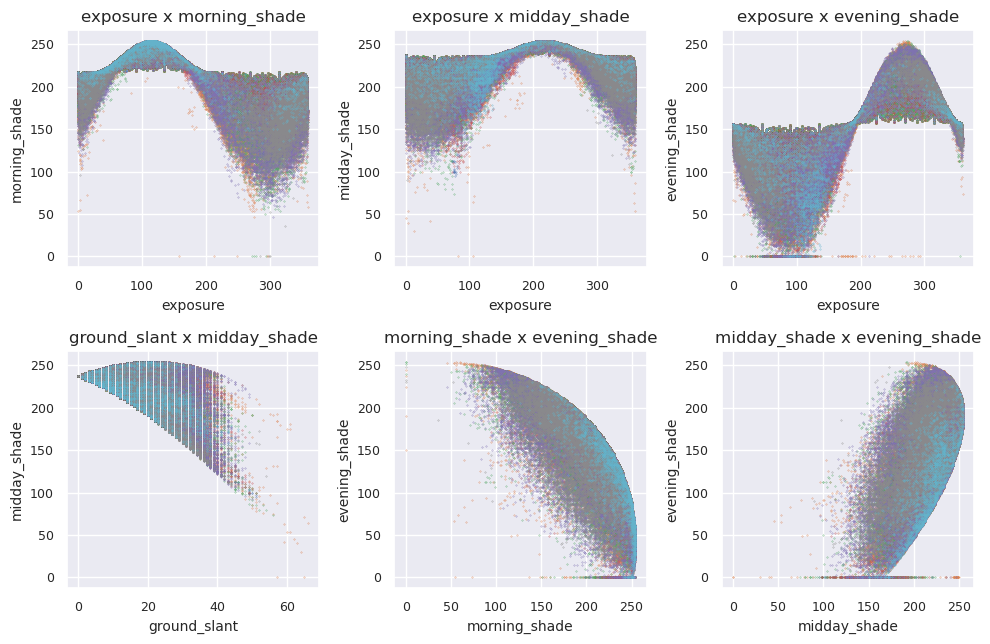

In [125]:
plt.rcParams["figure.figsize"] = (10,6.6)
fig, axs = plt.subplots(2,3)
plt_scatter(axs[0,0], 'exposure', 'morning_shade')
plt_scatter(axs[0,1], 'exposure', 'midday_shade')
plt_scatter(axs[0,2], 'exposure', 'evening_shade')
plt_scatter(axs[1,0], 'ground_slant', 'midday_shade')
plt_scatter(axs[1,1], 'morning_shade', 'evening_shade')
plt_scatter(axs[1,2], 'midday_shade', 'evening_shade')
plt.tight_layout()

The scatter plots allow to make the following observations:
- The three shade features are predictably correlated or anti-correlated with one another
- ground_slant shows correlation with midday_shade and, by extension, is informative of the other shade features as well
- exposure displays a significant non-linear correlation with the shade features, showing a sine-like pattern. This means that partitioning the exposure feature, which is the means through which tree type algorithms operate, also partitions the shade features.

These observations are arguments for discarding the shade features from the dataset, which would improve the speed of the training algorithms. An alternative to discarding the features is to apply a non-linear transformation to them, which could help de-correlate the features and preserve some of the information they contain. 

The following non-linear transformations are proposed: 
- max_shade: The highest value of shade recorded throghout the day.
- min_shade: The lowest value of shade recorded throghout the day.
- max_shade_time: The time of day when the highest value of shade was recorded.
- min_shade_time: The time of day when the lowest value of shade was recorded.

In [126]:
data['max_shade'] = [max([x,y,z]) for (x,y,z) in zip(X['morning_shade'],X['midday_shade'],X['evening_shade'])]
data['min_shade'] = [min([x,y,z]) for (x,y,z) in zip(X['morning_shade'],X['midday_shade'],X['evening_shade'])]
data['max_shade_time'] = [['morning','midday','evening'][np.argmax([x,y,z])] for (x,y,z) in zip(X['morning_shade'],X['midday_shade'],X['evening_shade'])]
data['min_shade_time'] = [['morning','midday','evening'][np.argmin([x,y,z])] for (x,y,z) in zip(X['morning_shade'],X['midday_shade'],X['evening_shade'])]

We can again observe the histograms of these derived features partitioned by the classes of the target feature to decide whether these proposed features are informative or not. 

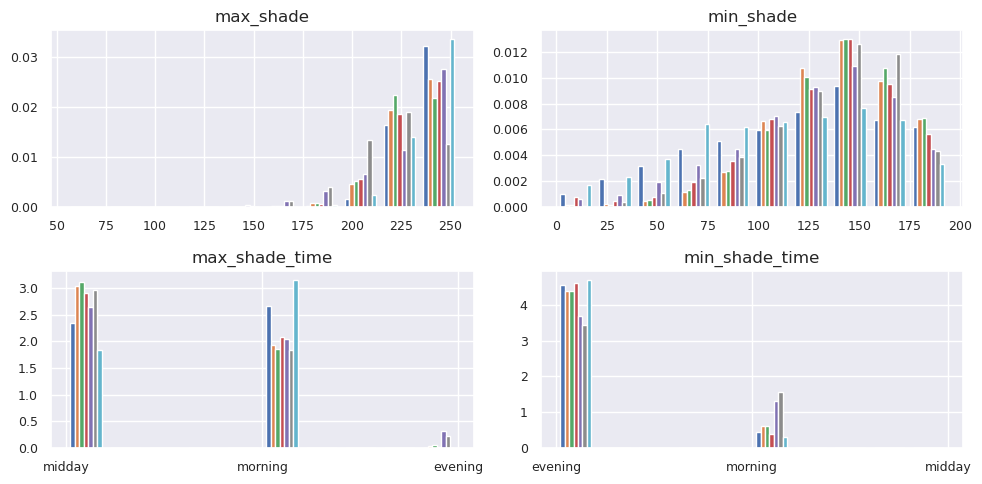

In [127]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["lines.markersize"] = 0.25
fig, axs = plt.subplots(2,2)

features = ['max_shade', 'min_shade', 'max_shade_time', 'min_shade_time']
k = 0
for i in range(0, 2):
    for j in range(0, 2):
        sel = [data[data[Y_feature]==i][features[k]] for i in data[Y_feature].unique()]
        axs[i,j].hist(sel, density=True)
        axs[i,j].title.set_text(features[k])
        axs[i,j].title.set_fontsize(12)
        k += 1
plt.tight_layout()

The histograms show that min_shade appears to be the most informative of the proposed derived features, no less informative than the original shade features present in the dataset.

## Preprocessing of Dataset

Given that we will use algorithms in the tree family that do not rely on notions of distance between datapoints, there is no need to normalize or otherwise scale the numerical features. 

For the categorical features, there is no reason to assume an incremental nature to the classes, so a case can be made for transforming them from ordinal encoding to one-hot encoding. One-hot encoding, however, makes it more difficult to analyze feature importance of the categorical feature, so ordinal encoding will be maintained. 

The only transformation that will be made is the removal of the original shade features, instead replacing them with the derived feature min_shade.

In [128]:
X = X.drop(columns=['morning_shade', 'midday_shade', 'evening_shade'])
X['min_shade'] = data['min_shade']

X

,altitude,exposure,ground_slant,water_distance,water_altitude,path_distance,fire_distance,wilderness_area,soil_class,min_shade
0,2596,51,3,258,0,510,6279,1,29,148
1,2804,139,9,268,65,3180,6121,1,12,135
2,2785,155,18,242,118,3090,6211,1,30,122
3,2595,45,2,153,-1,391,6172,1,29,150
4,2579,132,6,300,-15,67,6031,1,29,140
...,...,...,...,...,...,...,...,...,...,...
464805,2405,159,22,90,19,120,824,3,2,119
464806,2391,152,19,67,12,95,845,3,2,119
464807,2386,159,17,60,7,90,854,3,2,130
464808,2384,170,15,60,5,90,864,3,2,143


For the train-test split, 20% of the sample data will be set aside for testing the trained models. Given that the distrubution of classes for the Y feature is so uneven, the train test split will be stratified over the Y variable.

In [129]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)

x_train.columns = X.columns
x_test.columns = X.columns

## Decision Tree Model

For the purposes of comparison with other tree based models, first we attempt to train a single decision tree to classify the test data. 

In [130]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier()

def train_with(x_train, y_train, model):
    ti = time.time()
    model.fit(x_train, y_train)
    tf = time.time()
    print(f"Model of {type(model)} trained in {round(tf-ti,3)} seconds") 
    return model.predict(x_test)

y_pred = train_with(x_train, y_train, dt)

Model of <class 'sklearn.tree._classes.DecisionTreeClassifier'> trained in 2.345 seconds


We observe the performance of the trained model via the confusion matrix $C$. We also observe the accuracy score, which is simply the ratio of correct predictions to total predictions. Mathematically it is the trace of the confusion matrix divided by the sum of all its elements. 

$$
    \text{accuracy} = \frac{\sum_i C_{ii}}{\sum_i\sum_j C_{ij}}
$$

Since the dataset is unbalanced, the most appropriate metric to evaluate the performance of the model is the balanced accuracy score, which is defined as the average recall (ratio of samples in the test set that were correctly predicted) far each class. 

$$
    \text{balanced accuracy} = \frac 1 N \sum_i\left[\frac{C_{ii}}{\sum_j C_{ji}}\right]
$$

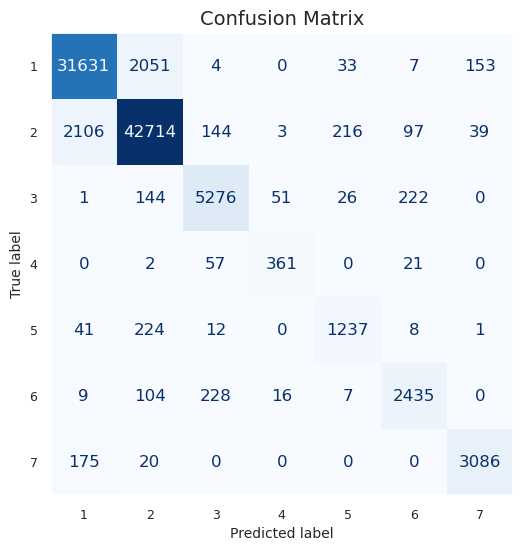

Accuracy Score: 0.933
Balanced Accuracy Score: 0.891


In [131]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["axes.grid"] = False

def view_confusion_matrix(y_test, y_pred):
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots(1,1)
    ax.title.set_text("Confusion Matrix")
    ax.title.set_fontsize("14")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    plt.show()
    print(f"Accuracy Score: {round(accuracy_score(y_test, y_pred),3)}\nBalanced Accuracy Score: {round(balanced_accuracy_score(y_test, y_pred),3)}")

view_confusion_matrix(y_test, y_pred)

The balanced accuracy score does not tell the full story, it is useful to detail which classes the model predicts well and which one it struggles with by using a performance table, showing details for each class. 


| Field             | Description                                                                                                   | Formula                                      |
| ----------------- | ------------------------------------------------------------------------------------------------------------- | :------------------------------------------: |
| `true_positives`  | The number of times the i-th class was corectly classified.                                                   | $C_{ii}$                                     | 
| `false_negatives` | The total times the model confused an element of the i-th class as belonging to another class.                | $\displaystyle\sum_{j\ne i}C_{ji}$           |
| `false_positives` | The total times the model confused an element of another class as belonging to the i-th class.                | $\displaystyle\sum_{j\ne i}C_{ij}$           |
| `recall`          | The ratio of elements in the i-th class (true positives + false negatives) that resulted in true positives.   | $\displaystyle\frac{C_{ii}}{\sum_{j}C_{ji}}$ |
| `precision`       | The ratio of classifications into the i-th class (true positives + false positives) that were true positives. | $\displaystyle\frac{C_{ii}}{\sum_{j}C_{ij}}$ | 

This summary will tell us which classes the model struggles the most to classify properly. 

In [132]:
def performance_table(y_test, y_pred):
    mat = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    return pd.DataFrame({'true_pos':  [mat[i,i] for i in range(1,N)],
                         'false_pos': [sum(mat[i,:])-mat[i,i] for i in range(1,N)],
                         'false_neg': [sum(mat[:,i])-mat[i,i] for i in range(1,N)],
                         'recall':    [f"{round(mat[i,i]/sum(mat[i,:])*100, 1)}%" for i in range(1,N)],
                         'precision': [f"{round(mat[i,i]/sum(mat[:,i])*100, 1)}%" for i in range(1,N)]},
                         index=[y_test.unique()[i] for i in range(1,N)])

performance_table(y_test, y_pred)

,true_pos,false_pos,false_neg,recall,precision
5,1237,286,282,81.2%,81.4%
4,361,80,70,81.9%,83.8%
1,31631,2248,2332,93.4%,93.1%
6,2435,364,355,87.0%,87.3%
3,5276,444,445,92.2%,92.2%
7,3086,195,193,94.1%,94.1%


The performance of the model is quite good, but could be better, the model struggles with the recall of classes **4** and **5**, which is to be expected because these are the classes that are rarest in the dataset. We expect this performance to improve by using ensemble methods. 

Scikit-Learn also allows us to view some properties of the trained decision tree. For example, the total number of leaf nodes and maximum depth until a leaf node is reached gives us an idea of the complexity of the model.

In [133]:
print(f"The decision tree has {dt.get_n_leaves()} leaf nodes and a maximum depth of {dt.get_depth()}.")

The decision tree has 21640 leaf nodes and a maximum depth of 38.


We can also observe the first few tiers of the decision tree to know what the most informative features are for a first order estimation. Each node of the decision tree summarizes the folowing relevant information:
- The feature and threshold that are used to partition the sample space.
- The impurity of samples at the node indicated by the Gini coefficient, where 1 indicates a maximally impure node and 0 indicates a pure node.
- The percentage of samples from the testing dataset that are present at that node.

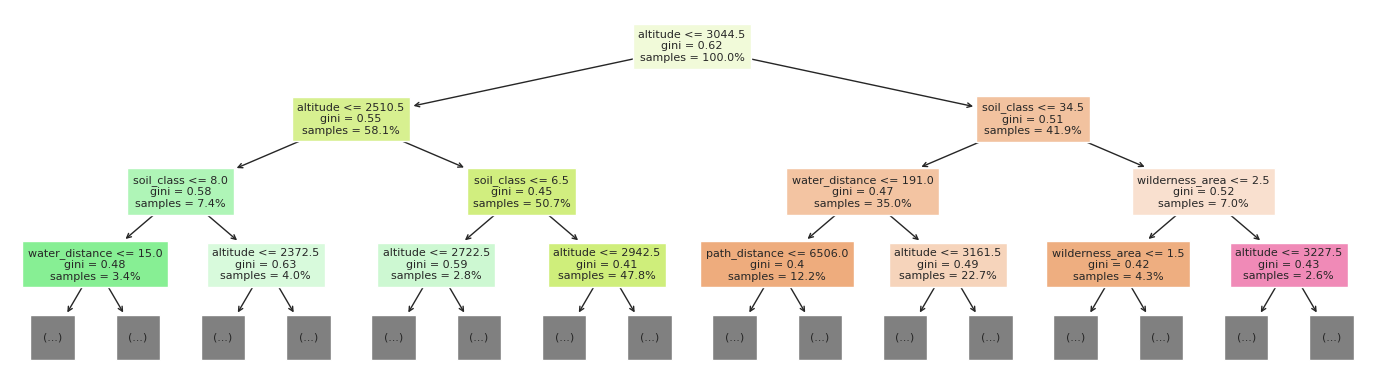

In [161]:
plt.rcParams["figure.figsize"] = (14,4)
fig, axs = plt.subplots(1,1)

def replace_text(obj):
    if type(obj) == mpl.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nvalue = \[.*\]","",txt)
        obj.set_text(txt)
    return obj
    
plot_tree(dt, max_depth=3, precision=2, feature_names=X.columns, filled=True, proportion=True, fontsize=8, ax=axs)
axs.properties()['children'] = [replace_text(i) for i in axs.properties()['children']]
plt.tight_layout()
plt.show()

The altitude feature regularly occupies the first decision of the tree, which is expected from the preliminary observaton of the dataset. The two categorical features often appear in subsequent decisions, which is also unsurprising. 

## Random Forest Model

We attempt to improve the results of the single decision tree model by using a random forest ensemble and comparing the resulting confusion matrix.

Model of <class 'daal4py.sklearn.ensemble._forest.RandomForestClassifier'> trained in 18.012 seconds


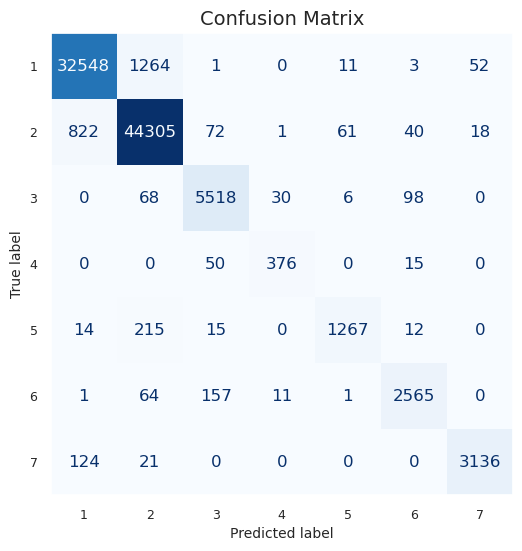

Accuracy Score: 0.965
Balanced Accuracy Score: 0.923


,true_pos,false_pos,false_neg,recall,precision
5,1267,256,79,83.2%,94.1%
4,376,65,42,85.3%,90.0%
1,32548,1331,961,96.1%,97.1%
6,2565,234,168,91.6%,93.9%
3,5518,202,295,96.5%,94.9%
7,3136,145,70,95.6%,97.8%


In [135]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300)

y_pred = train_with(x_train, y_train, rf)

view_confusion_matrix(y_test, y_pred)
performance_table(y_test, y_pred)

The metrics resulting from a random forest ensemble does show an improvement when compared to the single decision tree model, in particualry when it comes to its balanced accuracy metric.

We can observe some aspects of the random forest model to analyze its complexity, such as the number of trees, average leaf node count per tree, and average maximum depth of each tree.

In [136]:
ts = rf.estimators_
print(f"Trees in forest: {len(ts)}\nAvg. leaf nodes: {round(np.mean([t.get_n_leaves() for t in ts]))}\nAvg. max. depth: {round(np.mean([t.get_depth() for t in ts]))}")

Trees in forest: 300
Avg. leaf nodes: 25233
Avg. max. depth: 37


We can also observe a few of the decision trees generated by the random forest to see what features are informative in the event that the bootstrapping algorithm discards altitude as the first feature.

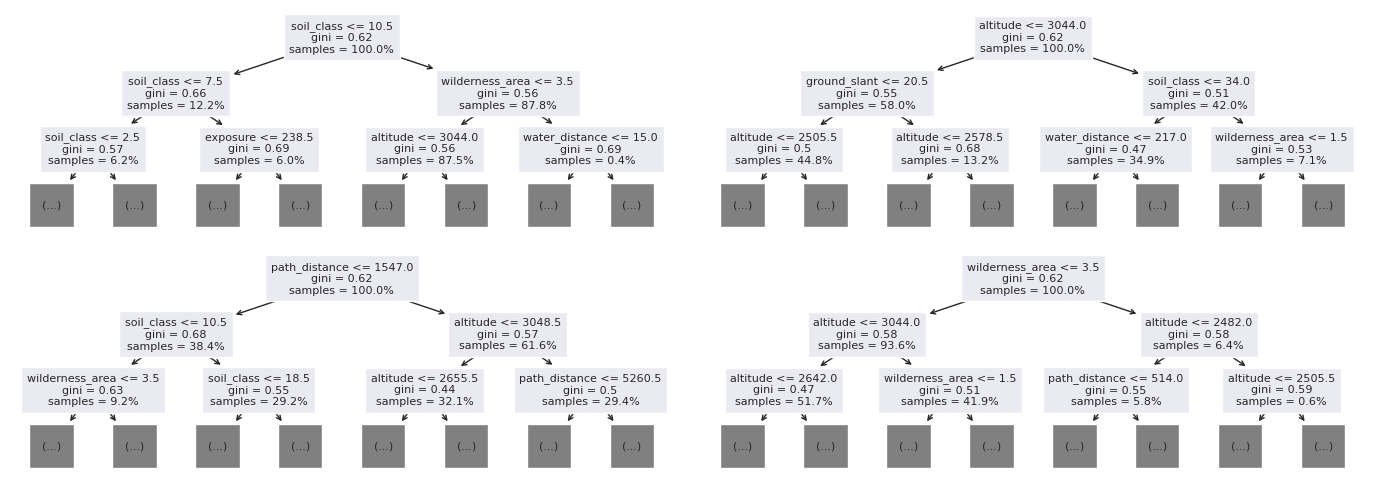

In [165]:
plt.rcParams["figure.figsize"] = (14,5)
fig, axs = plt.subplots(2,2)
k = 0;
for i in range(0,2):
    for j in range(0,2):
        t = rf.estimators_[k]
        plot_tree(t, max_depth=2, precision=2, feature_names=X.columns, proportion=True, fontsize=8, ax=axs[i][j])
        axs[i,j].properties()['children'] = [replace_text(i) for i in axs[i,j].properties()['children']]
        k += 1

plt.tight_layout()
plt.show()

## XGBoost Model

Finally, we compare with the XGBoost algorithm, which is expected to have an even better performance than Random Forest, but is also expected to take a longer time to train. 

We will choose a learning rate of 0.75. Smaller learning rates in the 0.1 to 0.3 range tend to produce better results, but also require many more estimators to converge, which can be impractical when not using some form of hardware acceleration. 

Model of <class 'xgboost.sklearn.XGBClassifier'> trained in 21.851 seconds


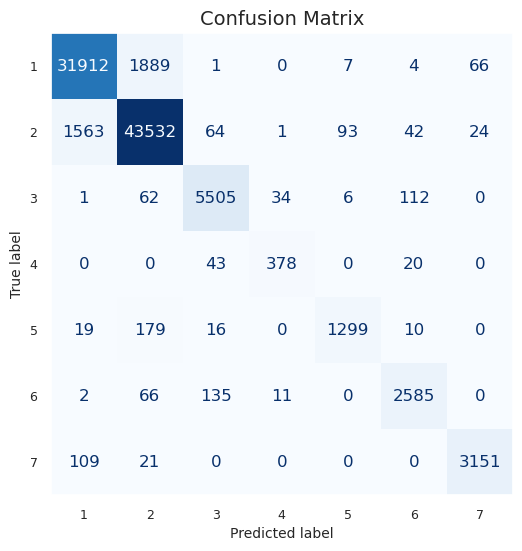

Accuracy Score: 0.951
Balanced Accuracy Score: 0.923


,true_pos,false_pos,false_neg,recall,precision
5,1299,224,106,85.3%,92.5%
4,378,63,46,85.7%,89.2%
1,31912,1967,1694,94.2%,95.0%
6,2585,214,188,92.4%,93.2%
3,5505,215,259,96.2%,95.5%
7,3151,130,90,96.0%,97.2%


In [138]:
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

xgb = XGBClassifier(n_estimators=300, learning_rate=0.75, verbosity=0, tree_method='hist')

y_pred = train_with(x_train, y_train, xgb)

view_confusion_matrix(y_test, y_pred)
performance_table(y_test, y_pred)

The `xgboost` API makes it very easy to visualize the importance of each feature, two metrics will be used to quantify their importance.

- Weight: The number of times the feature appears in a tree to make a decision 
- Coverage: The average number of samples affected when the feature is used

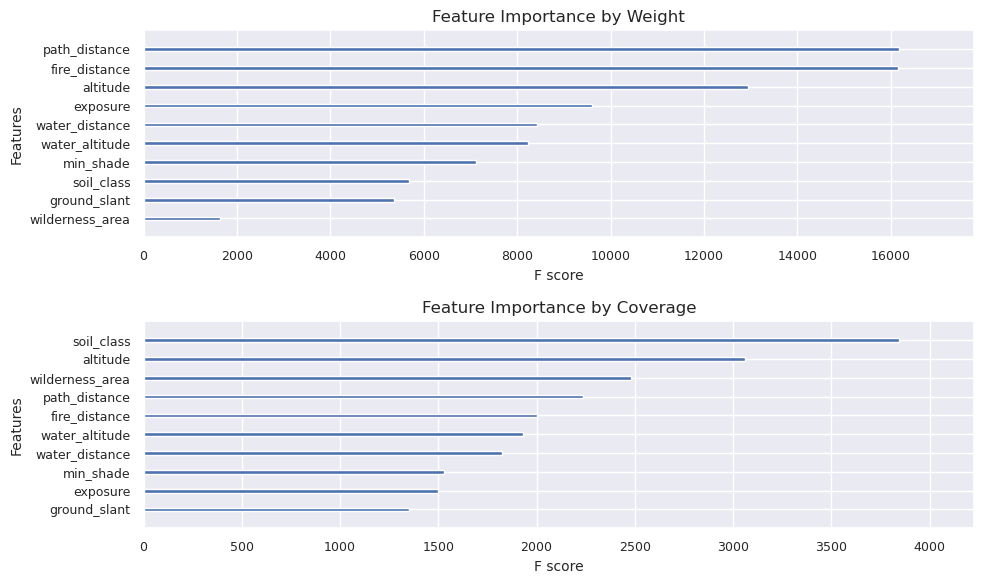

In [139]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (10,6)
fig, axs = plt.subplots(2,1)

plot_importance(xgb, ax=axs[0], show_values=False, importance_type='weight', title="Feature Importance by Weight")
plot_importance(xgb, ax=axs[1], show_values=False, importance_type='cover', title="Feature Importance by Coverage")
plt.tight_layout()
plt.show()

It is worth noting that a low feature score in both metrics does not necessarily mean that the feature is useless, especially if class distribution in the training set is unbalanced as is the case with our given data. 

For instance, a feature can be necessary for occasionally distinguishing between two uncommon classes yet score low in both metrics used, but would severely impact the balanced accuracy score if it were removed. 

## Cross Validation

The results so far seem to show that the XGBoost model has performance comparable to the Random Forest model with equal number of estimators, occasionally the results can be marginally better or marginally worse.

This is where K-fold cross validation is a useful tool, performing the train-test split multiple times in order to even out the randomness of performing a single train-test split.

Just as is the case with the single train-test split, we specify that the K-fold cross validation should be stratified by the Y feature.

In [140]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = cross_val_score(dt, X, Y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=5))
print(f"Average C.V. Score: {round(np.mean(cv),3)}\nStandard Deviation: {round(np.std(cv),3)}")

Average C.V. Score: 0.677
Standard Deviation: 0.036


In [141]:
cv = cross_val_score(rf, X, Y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=5))
print(f"Average C.V. Score: {round(np.mean(cv),3)}\nStandard Deviation: {round(np.std(cv),3)}")

Average C.V. Score: 0.713
Standard Deviation: 0.039


In [142]:
cv = cross_val_score(xgb, X, Y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=5))
print(f"Average C.V. Score: {round(np.mean(cv),3)}\nStandard Deviation: {round(np.std(cv),3)}")

Average C.V. Score: 0.712
Standard Deviation: 0.039


The Random Forest and XGBoost models do seem to in fact have identical performance for the number of estimators used. 

This is not too alarming, since it can be justified by the fact that the number of estimators required for XGBoost to outperform Random Forest is much higher and only becomes practical with longer execution times on more powerful hardware. 